# About this notebook....
This notebook give the overview of how to perform cutmix, mixup, Gridmask and Cutout data augmentation. And analyse the performance of AUgmentation.

Augmentation help to improve model performance, but it depend on various things, like what is the problem statement, Which Augmentation help to improve the performance, Ratio of Augmentation etc...


## <font color='red'>If you find it helpful please upvote it. Thanks!<font>


## Refrences...
* Thanks Chris Deotte for your kernal help.
* Starter kernal help.[click here](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu)

## My other work on kaggle...
* Melanoma Image classification.[click here](https://www.kaggle.com/saife245/melanoma-detail-analysis-eda-ip-augmentation-model/notebook?scriptVersionId=35184465)
* Reticultae- journey of python in r.[click here](https://www.kaggle.com/saife245/reticulate-a-journey-of-python-in-r)
* Squeezenet- model of size 0.5mb.[click here](https://www.kaggle.com/saife245/squeezenet-model-size-of-0-5mb-is-it-true)
* NeuroImaging Depth Analysis.[click here](https://www.kaggle.com/saife245/neuroimaging-in-depth-understanding-eda-model)

## Why Data Augmentation is Needed?

Given the limited set of data, one can train the model by applying variations to the existing image. Such modification to the image increases the overall size of the dataset, thereby contributing to the model’s robustness. Thus, data augmentation strategies that enhance localization and generalization performance have been suggested to ameliorate the performance of convolutional neural network classifiers.
## CutMix vs MixUp vs Gridmask vs CutOut Augmentation
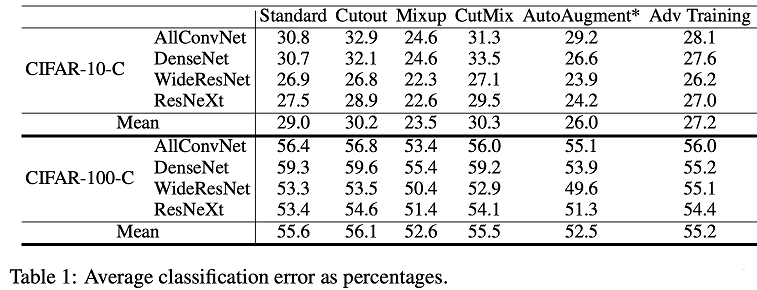

In [ ]:
import random, re, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
print('Tensorflow version ' + tf.__version__)


In [ ]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus')
GCS_PATH = os.path.join(GCS_DS_PATH, 'tfrecords-jpeg-512x512')
TEST_FNS = tf.io.gfile.glob(os.path.join(GCS_PATH, 'test/*.tfrec'))
AUG_BATCH = 48
BATCH_SIZE = 48
IMAGE_SIZE = [512, 512]
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
row = 6; col = 4;

thnaks for starter [kernal](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu)

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # Diregarding data order. Order does not matter since we will be shuffling the data anyway
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # use data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO) # returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeld = False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset(dataset, do_aug=True):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.batch(AUG_BATCH)
    if do_aug: dataset = dataset.map(transform, num_parallel_calls=AUTO) # note we put AFTER batching
    dataset = dataset.unbatch()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset


# GridMask data augmentation

GridMask is belong to Information dropping method. Information dropping might help improving model generalization through enforcing model to learn on remain information. But keeping the deletion and reservation region in a balance relation is needed. Too much information dropping might result in under-fitting, but too few might result in over-fitting.

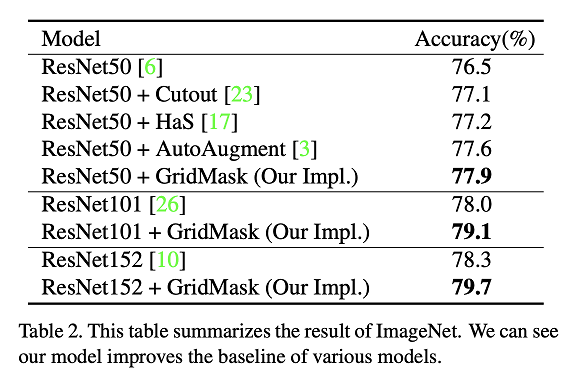

Get more Details from [here](https://arxiv.org/abs/2001.04086)

In [ ]:
def transform(image, inv_mat, image_shape):
    h, w, c = image_shape
    cx, cy = w//2, h//2
    new_xs = tf.repeat( tf.range(-cx, cx, 1), h)
    new_ys = tf.tile( tf.range(-cy, cy, 1), [w])
    new_zs = tf.ones([h*w], dtype=tf.int32)
    old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
    old_coords_x, old_coords_y = tf.round(old_coords[0, :] + w//2), tf.round(old_coords[1, :] + h//2)
    clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x>w-1)
    clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y>h-1)
    clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)
    old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
    old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
    new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
    new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))
    old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
    new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
    rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
    rotated_image_channel = list()
    for i in range(c):
        vals = rotated_image_values[:,i]
        sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h, w])
        rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value=0, validate_indices=False))
    return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])

def random_rotate(image, angle, image_shape):
    def get_rotation_mat_inv(angle):
        # transform to radian
        angle = math.pi * angle / 180
        cos_val = tf.math.cos(angle)
        sin_val = tf.math.sin(angle)
        one = tf.constant([1], tf.float32)
        zero = tf.constant([0], tf.float32)
        rot_mat_inv = tf.concat([cos_val, sin_val, zero, -sin_val, cos_val, zero, zero, zero, one], axis=0)
        rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])
        return rot_mat_inv
    angle = float(angle) * tf.random.normal([1],dtype='float32')
    rot_mat_inv = get_rotation_mat_inv(angle)
    return transform(image, rot_mat_inv, image_shape)


def GridMask(image_height, image_width, d1, d2, rotate_angle=1, ratio=0.5):
    h, w = image_height, image_width
    hh = int(np.ceil(np.sqrt(h*h+w*w)))
    hh = hh+1 if hh%2==1 else hh
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int32)
    l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

    st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
    st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

    y_ranges = tf.range(-1 * d + st_h, -1 * d + st_h + l)
    x_ranges = tf.range(-1 * d + st_w, -1 * d + st_w + l)

    for i in range(0, hh//d+1):
        s1 = i * d + st_h
        s2 = i * d + st_w
        y_ranges = tf.concat([y_ranges, tf.range(s1,s1+l)], axis=0)
        x_ranges = tf.concat([x_ranges, tf.range(s2,s2+l)], axis=0)

    x_clip_mask = tf.logical_or(x_ranges < 0 , x_ranges > hh-1)
    y_clip_mask = tf.logical_or(y_ranges < 0 , y_ranges > hh-1)
    clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

    x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
    y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)), tf.int32)])
    x_ranges = tf.repeat(x_ranges, hh)
    y_ranges = tf.repeat(y_ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(y_ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = random_rotate(mask, rotate_angle, [hh, hh, 1])
    mask = tf.image.crop_to_bounding_box(mask, (hh-h)//2, (hh-w)//2, image_height, image_width)

    return mask

def apply_grid_mask(image, image_shape):
    AugParams = {
        'd1' : 100,
        'd2': 160,
        'rotate' : 45,
        'ratio' : 0.3
    }
    mask = GridMask(image_shape[0], image_shape[1], AugParams['d1'], AugParams['d2'], AugParams['rotate'], AugParams['ratio'])
    if image_shape[-1] == 3:
        mask = tf.concat([mask, mask, mask], axis=-1)
    return image * tf.cast(mask,tf.float32)

def gridmask(img_batch, label_batch):
    return apply_grid_mask(img_batch, (512,512, 3)), label_batch

In [ ]:

row = min(row,AUG_BATCH//col)
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(AUG_BATCH).map(gridmask)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# CutMix data augmentation

CutMix augmentation strategy: patches are cut and pasted among training images where the ground truth labels are also mixed proportionally to the area of the patches. By making efficient use of training pixels and retaining the regularization effect of regional dropout, CutMix consistently outperforms the state-of-the-art augmentation strategies on CIFAR and ImageNet classification tasks, as well as on the ImageNet weakly-supervised localization task. 
CutMix improves the model robustness against input corruptions and its out-of-distribution detection performances.

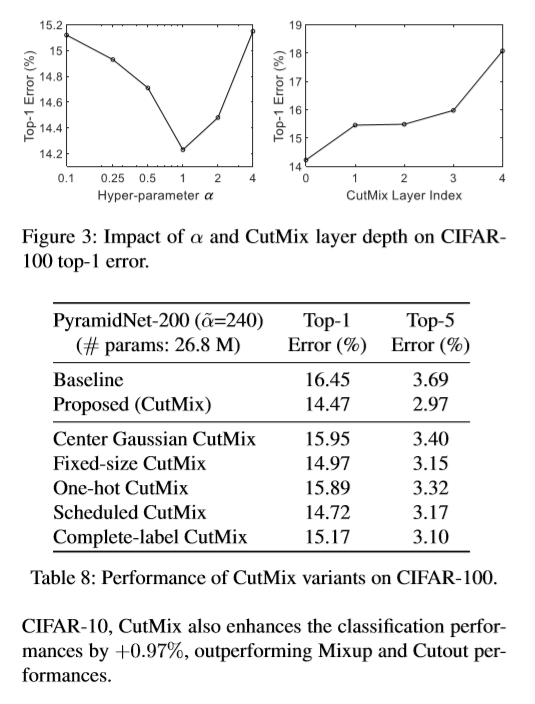

More details at [here](https://arxiv.org/abs/1905.04899)

In [ ]:
def onehot(image,label):
    CLASSES = 104
    return image,tf.one_hot(label,CLASSES)

def cutmix(image, label): #, PROBABILITY = 1.0
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32)
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [ ]:

row = min(row,AUG_BATCH//col)
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(AUG_BATCH).map(cutmix)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# MixUp data augmentation

Mixup augmentation is a type of augmentation where in we form a new image through weighted linear interpolation of two existing images. We take two images and do a linear combination of them in terms of tensors of those images.
Mixup reduces the memorization of corrupt labels, increases the robustness to adversarial examples, and stabilizes the training of generative adversarial networks.

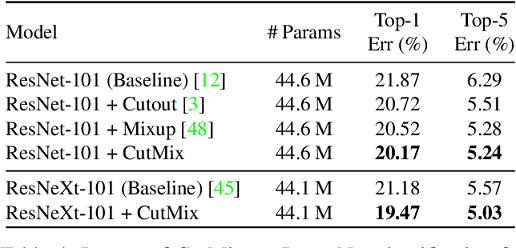

Mixup are well explain [here](https://arxiv.org/abs/1710.09412)

In [ ]:
def mixup(image, label):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

In [ ]:
row = 6; col = 4;
row = min(row,AUG_BATCH//col)
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(AUG_BATCH).map(mixup)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

# Cutout data augmentation

Cutout is a simple regularization technique for convolu- tional neural networks that involves removing contiguous sections of input images, effectively augmenting the dataset with partially occluded versions of existing samples.

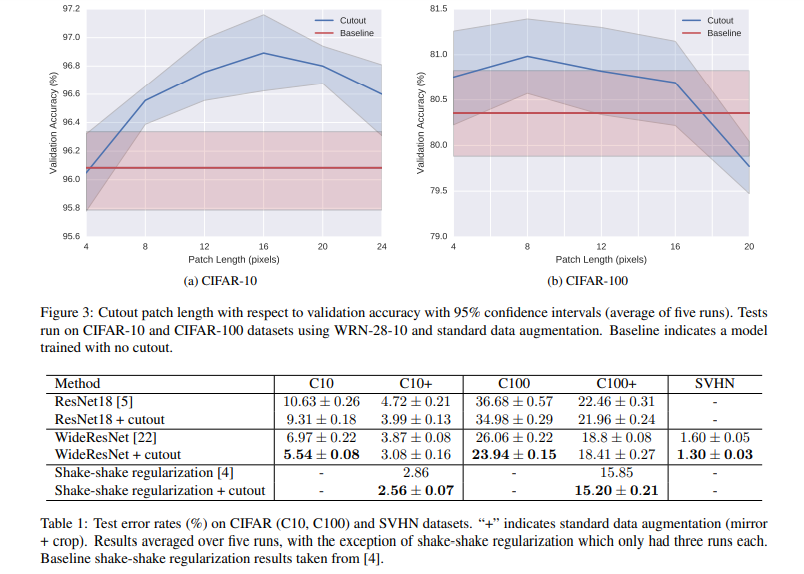

cutout explain [here](https://arxiv.org/pdf/1708.04552.pdf)

In [ ]:
def get_random_eraser(input_img,p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
   # def eraser(input_img):
    img_h, img_w, img_c = input_img.shape
#     p_1 = np.random.rand()
#     if p_1 > p:
#         return input_img

    while True:
        s = np.random.uniform(s_l, s_h) * img_h * img_w
        r = np.random.uniform(r_1, r_2)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break

    if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img

In [ ]:
TRAIN = '../input/flower-image/'
IMAGE_SIZE = 512
import cv2
n_imgs = 12
img_filenames = os.listdir(TRAIN)[:n_imgs]
img_filenames[:3]
cols, rows = 4, 3
image=[]
def grid_display(list_of_images, no_of_columns=2, figsize=(15,15)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')

for file_name in img_filenames:
    img = cv2.imread(TRAIN +file_name)
    img = get_random_eraser(img)
    image.append(img)
grid_display(image, 4, (15,15))

## There are lot other in image Augmentation...

### Data augmentation strategies that enhance localization and generalization performance have been suggested to ameliorate the performance of convolutional neural network classifiers.
### You can apply it to the various classification problem...
### like on kaggle...
* Flower Classification
* ISIC Melanoma Classification
* Global wheet Detection..

Applying Augmentation On Melanoma Classification

In [ ]:
TRAIN = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
IMAGE_SIZE = 1024
import cv2
n_imgs = 12
img_filenames = os.listdir(TRAIN)[:n_imgs]
img_filenames[:3]
cols, rows = 4, 3
image=[]
def grid_display(list_of_images, no_of_columns=2, figsize=(15,15)):

    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')

for file_name in img_filenames:
    img = cv2.imread(TRAIN +file_name)
    img = get_random_eraser(img)
    image.append(img)
grid_display(image, 4, (15,15))

## You can also apply different augmentation.You can also check out my work on this.[Click here](https://www.kaggle.com/saife245/melanoma-detail-analysis-eda-ip-augmentation-model/notebook?scriptVersionId=35184465)

### Thanks for reading....

## <font color='blue'>If you think this kernal will help you, please upvote it.;)<font>